In [1]:
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb

Define a convenience function to show two images side by side:

In [2]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()



Read the image, convert it to grayscale and use Otsus method to compute and apply a threshold.

Show the binary image together with the original image.

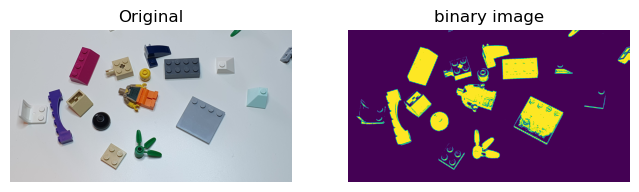

In [3]:
name = 'lego_4_small.png'
dir = 'data/'

img_org = io.imread(dir+name)

img_gray = color.rgb2gray(img_org)

threshold = threshold_otsu(img_gray)

img_binary = img_gray < threshold

show_comparison(img_org, img_binary, "binary image")

Use segmentation.clear_border to remove border pixels from the binary image.

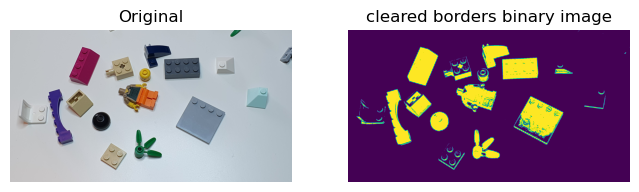

In [4]:
img_binary_cleared = segmentation.clear_border(img_binary)

show_comparison(img_org, img_binary_cleared, "cleared borders binary image")

In order to remove remove noise and close holes, you should do a morphological closing followed by a morphological opening with a disk shaped structuring element with radius 5. See Exercise 4b if you are in doubt.

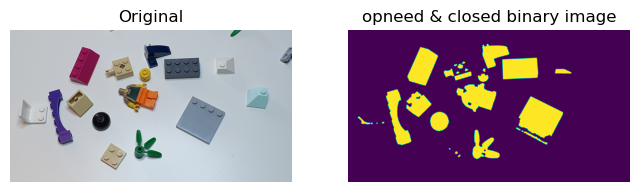

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]]


In [5]:
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk 

footprint = disk(5)

img_binary_closed = closing(img_binary_cleared, footprint)

img_binary_opened = opening(img_binary_closed, footprint)

show_comparison(img_org, img_binary_opened, "opneed & closed binary image")

print(footprint)

The actual connected component analysis / BLOB analysis is performed using measure.label :

In [6]:
label_img = measure.label(img_binary_opened)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 29


We can use the function label2rbg to create a visualization of the found BLOBS. Show this together with the original image.

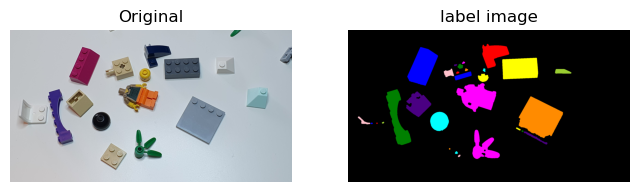

In [7]:
show_comparison(img_org, color.label2rgb(label_img), "label image")

It is possible to compute a wide variety of BLOB features using the measure.regionprops function:

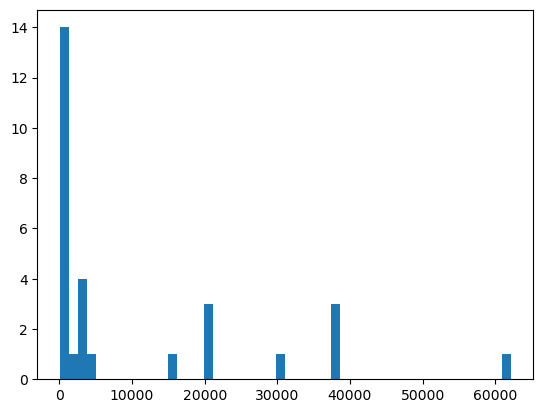

In [8]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

To make it easier to develop the cell counting program we start by working with smaller areas of the raw images. The images are also converted to 8 bit grayscale images:

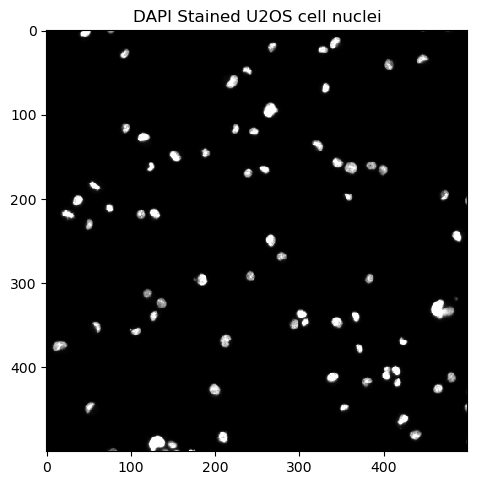

In [9]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample G1 - COS7 cells DAPI channel.tiff')
# slice to extract smaller image
img_small = img_org[700:1200, 900:1400]
img_gray = img_as_ubyte(img_small) 
io.imshow(img_gray, vmin=0, vmax=60)
plt.title('DAPI Stained U2OS cell nuclei')
io.show()

Initially, we would like to apply a threshold to create a binary image where nuclei are foreground. To select a good threshold, inspect the histogram:

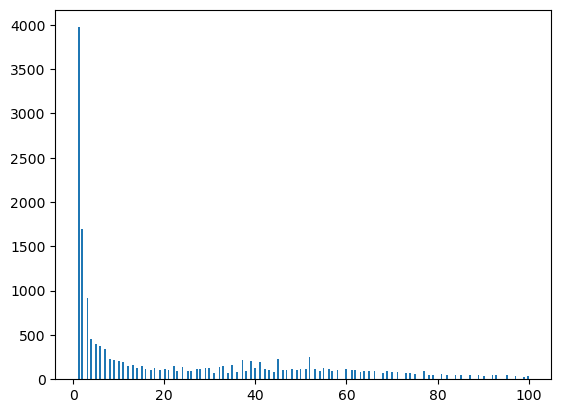

In [10]:
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
io.show()

Select an appropriate threshold, that seperates nuclei from the background. You can set it manually or use Otsus method.

Show the binary image together with the original image and evaluate if you got the information you wanted in the binary image.

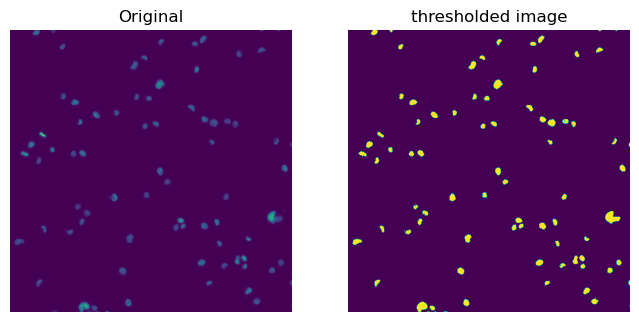

In [11]:
img_binary = threshold_otsu(img_gray) < img_gray

show_comparison(img_small, img_binary, "thresholded image")

Use segmentation.clear_border to remove border pixels from the binary image.

To be able to analyse the individual objects, the objects should be labelled.

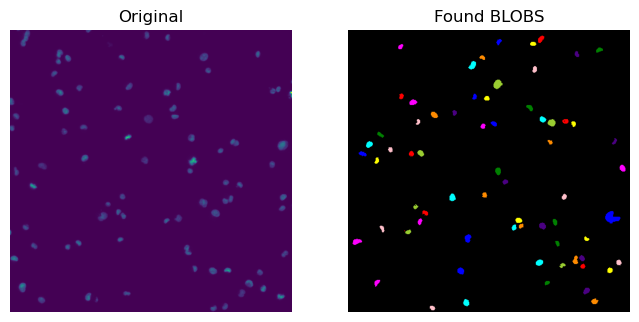

In [12]:
img_c_b = segmentation.clear_border(img_binary)

label_img = measure.label(img_c_b)
image_label_overlay = label2rgb(label_img)
show_comparison(img_org, image_label_overlay, 'Found BLOBS')

The task is now to find some object features that identify the cell nuclei and let us remove noise and connected nuclei. We use the function regionprops to compute a set of features for each object:

In [13]:
region_props = measure.regionprops(label_img)

print(region_props[0].area)

96


A quick way to gather all areas:

In [14]:
areas = np.array([prop.area for prop in region_props])

Plot a histogram of all the areas and see if it can be used to identify well separated nuclei from overlapping nuclei and noise.

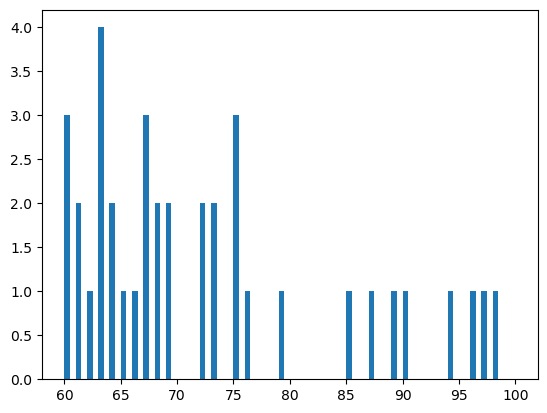

In [15]:
plt.hist(areas, bins=80, range=(60, 100))
io.show()

Select a minimum and maximum allowed area and use the following to visualise the result:

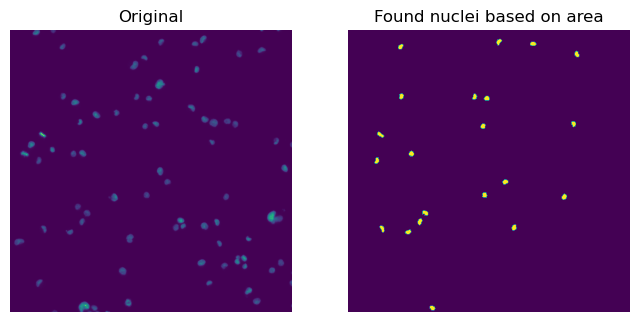

In [16]:
min_area = 60
max_area = 70

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

Extract all the perimeters of the BLOBS:

In [17]:
perimeters = np.array([prop.perimeter for prop in region_props])

Try to plot the areas versus the perimeters.

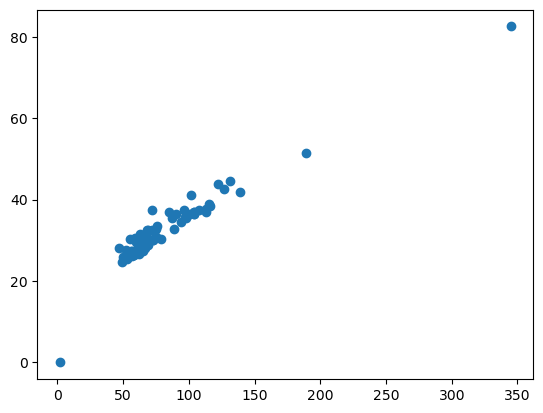

In [18]:
plt.scatter(areas, perimeters)

Compute the circularity for all objects and plot a histogram.

Select some appropriate ranges of accepted circularity. Use these ranges to select only the cells with acceptable areas and circularity and show them in an image.

C:\Users\birdl\AppData\Local\Temp\ipykernel_28972\1604685639.py:1: RuntimeWarning: divide by zero encountered in divide
  circularity = np.array((4*np.pi*areas)/np.power(perimeters,2))
C:\Users\birdl\AppData\Local\Temp\ipykernel_28972\1604685639.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if np.array((4*np.pi*region.area)/np.power(region.perimeter,2)) > max_circularity or np.array((4*np.pi*region.area)/np.power(region.perimeter,2)) < min_circularity:


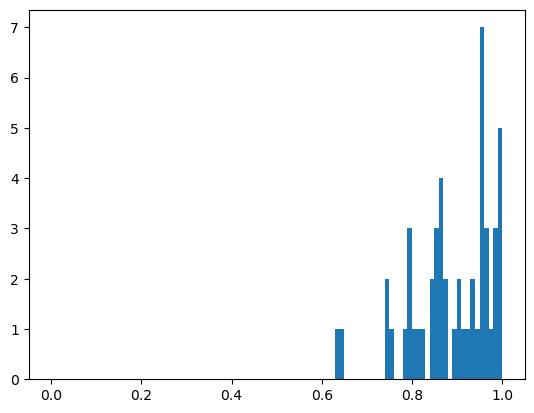

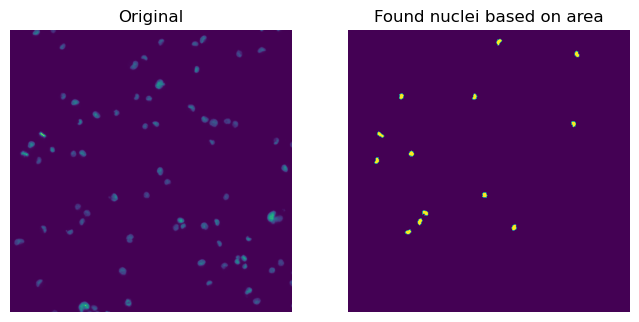

In [19]:
circularity = np.array((4*np.pi*areas)/np.power(perimeters,2))

plt.hist(circularity, bins=100, range=(0,1))

min_circularity = 0.8
max_circularity = 1

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if np.array((4*np.pi*region.area)/np.power(region.perimeter,2)) > max_circularity or np.array((4*np.pi*region.area)/np.power(region.perimeter,2)) < min_circularity:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

Try to plot the areas versus the circularity. What do you observe?

Extend your method to return the number (the count) of well-formed nuclei in the image.

60


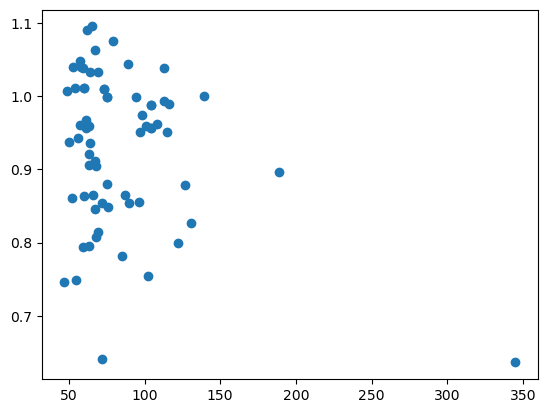

In [20]:
plt.scatter(areas, circularity)
print(np.count_nonzero(circularity > 0.8))

Try to test the method on a larger set of training images. Use slicing to select the different regions from the raw image.

In certain cases cell nuclei are touching and are therefore being treated as one object. It can sometimes be solved using for example the morphological operation opening before the object labelling. The operation erosion can also be used but it changes the object area.